In [2]:
import datasets
import re

DATASETS = ['pubmed_qa', 'writingprompts']
DATA_PATH = 'data/writingPrompts'
NUM_EXAMPLES = 150
TAGS = ['[ WP ]', '[ OT ]', '[ IP ]', '[ HP ]', '[ TT ]', '[ Punch ]', '[ FF ]', '[ CW ]', '[ EU ]']


def strip_newlines(text):
    """
    Removes newline characters from a string.
    """
    return ' '.join(text.split())


def process_text(text, replacements):
    """
    Performs a series of replacements in a string.
    """
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text


def remove_whitespace_before_punctuations(text):
    """
    Removes whitespace before punctuation marks in a string.
    """
    return re.sub(r'\s([?.!,:;](?:\s|$))', r'\1', text)


def load_pubmed(num_examples=NUM_EXAMPLES):
    """
    Loads the PubMed QA dataset.
    """
    data = datasets.load_dataset('pubmed_qa', 'pqa_labeled', split=f'train[:{num_examples}]')
    data = [(f'Question: {q} Answer: {a}', 0) for q, a in zip(data['question'], data['long_answer'])]
    return data


def load_writingPrompts_dataset(data_path=DATA_PATH, num_examples=NUM_EXAMPLES):
    """
    Loads the WritingPrompts dataset.
    """
    with open(f'{data_path}/valid.wp_source', 'r', encoding='utf-8') as f:
        prompts = f.readlines()[:num_examples]
    with open(f'{data_path}/valid.wp_target', 'r', encoding='utf-8') as f:
        stories = f.readlines()[:num_examples]

    prompt_replacements = {tag: '' for tag in TAGS}
    prompts = [process_text(prompt, prompt_replacements) for prompt in prompts]
    prompts = [remove_whitespace_before_punctuations(prompt) for prompt in prompts]

    story_replacements = {
        ' ,': ',',
        ' .': '.',
        ' ?': '?',
        ' !': '!',
        ' ;': ';',
        ' \'': '\'',
        ' ’ ': '\'',
        ' :': ':',
        '<newline>': '\n',
        '`` ': '"',
        ' \'\'': '"',
        '\'\'': '"',
        '.. ': '... ',
        ' )': ')',
        '( ': '(',
        ' n\'t': 'n\'t',
        ' i ': ' I ',
        ' i\'': ' I\'',
        '\\\'': '\'',
        '\n ': '\n',
    }
    stories = [process_text(story, story_replacements).strip() for story in stories]
    joined = ["Prompt:" + prompt + " Story: " + story for prompt, story in zip(prompts, stories)]
    filtered = [story for story in joined if 'nsfw' not in story.lower()]
    data = [(story, 0) for story in filtered]
    return data


def load_data(dataset_name):
    """
    Loads a dataset based on its name.
    """
    if dataset_name == 'pubmed_qa':
        return load_pubmed()
    elif dataset_name == 'writingprompts':
        return load_writingPrompts_dataset()
    else:
        raise ValueError(f"Dataset name {dataset_name} not recognized.")


def preprocess_data(dataset):
    """
    Preprocesses a dataset.
    """
    if dataset not in DATASETS:
        raise ValueError(f"Dataset name {dataset} not recognized.")

    data = load_data(dataset)
    data = list(dict.fromkeys(data))
    data = [(strip_newlines(q).strip(), a) for q, a in data]
    if dataset == 'pubmed_qa':
        print(f"Loaded and pre-processed {len(data)} questions from the dataset")  # debug print

    if dataset == 'writingprompts':
        long_data = [(x, y) for x, y in data if len(x.split()) > 250]
        if len(long_data) > 0:
            data = long_data
        print(f"Loaded and pre-processed {len(data)} prompts/stories from the dataset")  # debug print
    return data

In [6]:
import spacy
from collections import Counter
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from transformers import BertTokenizerFast
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt


# Constants
nlp = spacy.load('en_core_web_sm')
FUNCTION_WORDS = {'a', 'in', 'of', 'the'}


def count_pos_tags_and_special_elements(text):
    # CHECKED
    """
    Counts the frequency of POS tags, punctuation marks and function words in a given text.

    Args:
    text (str): The text for which to count POS tags and special elements.

    Returns:
    tuple: A tuple containing two dictionaries, where keys are POS tags and punctuation marks
           and values are their corresponding count.
    """
    # Use SpaCy to parse the text
    doc = nlp(text)

    # Create a counter of POS tags
    pos_counts = Counter(token.pos_ for token in doc)

    # Create a counter of punctuation marks
    punctuation_counts = Counter(token.text for token in doc if token.pos_ == 'PUNCT')

    # Create a counter of function words
    function_word_counts = Counter(token.text for token in doc if token.lower_ in FUNCTION_WORDS)

    return dict(pos_counts), dict(punctuation_counts), dict(function_word_counts)


def load_and_count(dataset_name, data):
    # CHECKED
    # Extract texts
    texts, labels = zip(*data)

    # Split questions and answers for pubmed_qa dataset
    if dataset_name == 'pubmed_qa':
        texts = [text.split("Answer:", 1)[1].strip() for text in texts]  # Strip the 'Answer:' prefix
    elif dataset_name == 'writingprompts':
        texts = [text.split("Story:", 1)[1].strip() for text in texts]  # Stripping the 'Story: ' string

    # Calculate POS tag frequencies for the texts
    pos_frequencies, punctuation_frequencies, function_word_frequencies = zip(
        *[count_pos_tags_and_special_elements(text) for text in texts])

    # Then, sum the dictionaries to get the overall frequencies
    overall_pos_counts = Counter()
    for pos_freq in pos_frequencies:
        overall_pos_counts += Counter(pos_freq)

    overall_punctuation_counts = Counter()
    for punct_freq in punctuation_frequencies:
        overall_punctuation_counts += Counter(punct_freq)

    overall_function_word_counts = Counter()
    for function_word_freq in function_word_frequencies:
        overall_function_word_counts += Counter(function_word_freq)

    return overall_pos_counts, overall_punctuation_counts, overall_function_word_counts


def load_model():
    #CHECKED
    """
    Load the model and tokenizer.
    Returns a model and tokenizer.
    """
    model_name = 'allenai/scibert_scivocab_uncased'
    model = AutoModelForMaskedLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    return model, tokenizer


def calculate_average_sentence_length(texts):
    #CHEKCED
    """
    Calculate the average sentence length of a list of texts using SpaCy.

    Args:
    texts (list): The list of texts.

    Returns:
    float: The average sentence length.
    """
    sentence_lengths = []

    for text in texts:
        doc = nlp(text)
        for sent in doc.sents:
            sentence_lengths.append(len(sent))

    return mean(sentence_lengths)


def calculate_perplexity(text, model, tokenizer):
    #CHECKED
    """
    Calculate the perplexity of a piece of text.
    """
    # tokenize the input, add special tokens and return tensors
    input_ids = tokenizer.encode(text, return_tensors="pt")

    # if the text is too long, skip it
    # this step has the extra effect of removing examples with low-quality/garbage content
    if len(input_ids[0]) > 512:
        return None

    with torch.no_grad():
        output = model(input_ids, labels=input_ids)
    loss = output.loss
    return torch.exp(loss).item()  # perplexity is e^loss


def compute_statistics(dataset_name, data):
    #CHECKED
    texts, labels = zip(*data)
    if dataset_name == 'pubmed_qa':
        texts = [text.split("Answer:", 1)[1].strip() for text in texts]  # Stripping the 'Answer: ' string
    elif dataset_name == 'writingprompts':
        texts = [text.split("Story:", 1)[1].strip() for text in texts]  # Stripping the 'Story: ' string
    model, tokenizer = load_model()
    overall_pos_counts, overall_punctuation_counts, overall_function_word_counts = load_and_count(dataset_name, data)
    average_sentence_length = calculate_average_sentence_length(texts)
    text_perplexities = [calculate_perplexity(text, model, tokenizer) for text in texts]
    text_perplexities = [p for p in text_perplexities if p is not None]
    average_text_perplexity = sum(text_perplexities) / len(text_perplexities)
    sentences = [sentence.text for text in texts for sentence in nlp(text).sents]
    sentence_perplexities = [calculate_perplexity(sentence, model, tokenizer) for sentence in sentences]
    sentence_perplexities = [p for p in sentence_perplexities if p is not None]
    average_sentence_perplexity = sum(sentence_perplexities) / len(sentence_perplexities)
    return {
        'pos_freqs': overall_pos_counts,
        'punctuation_freqs': overall_punctuation_counts,
        'function_word_freqs': overall_function_word_counts,
        'average_sentence_length': average_sentence_length,
        'average_text_perplexity': average_text_perplexity,
        'average_sentence_perplexity': average_sentence_perplexity,
        'sentence_perplexities': sentence_perplexities,  # added this
        'text_perplexities': text_perplexities  # and this
    }


def print_statistics(statistics):
    #CHECKED
    pos_freqs = statistics['pos_freqs']
    punctuation_freqs = statistics['punctuation_freqs']
    function_word_freqs = statistics['function_word_freqs']

    print(f"Frequency of adjectives: {pos_freqs.get('ADJ', 0)}")
    print(f"Frequency of adverbs: {pos_freqs.get('ADV', 0)}")
    print(f"Frequency of conjunctions: {pos_freqs.get('CCONJ', 0)}")
    print(f"Frequency of nouns: {pos_freqs.get('NOUN', 0)}")
    print(f"Frequency of numbers: {pos_freqs.get('NUM', 0)}")
    print(f"Frequency of pronouns: {pos_freqs.get('PRON', 0)}")
    print(f"Frequency of verbs: {pos_freqs.get('VERB', 0)}")
    print(f"Frequency of commas: {punctuation_freqs.get(',', 0)}")
    print(f"Frequency of fullstops: {punctuation_freqs.get('.', 0)}")
    print(f"Frequency of special character '-': {punctuation_freqs.get('-', 0)}")
    print(f"Frequency of function word 'a': {function_word_freqs.get('a', 0)}")
    print(f"Frequency of function word 'in': {function_word_freqs.get('in', 0)}")
    print(f"Frequency of function word 'of': {function_word_freqs.get('of', 0)}")
    print(f"Frequency of function word 'the': {function_word_freqs.get('the', 0)}")
    print(f"Average sentence length: {statistics['average_sentence_length']}")
    print(f"Average sentence perplexity: {statistics['average_sentence_perplexity']}")
    print(f"Average text perplexity: {statistics['average_text_perplexity']}")

def plot_perplexities(sentence_perplexities, text_perplexities):
    """
    Plots Kernel Density Estimates of the sentence and text perplexities.

    Args:
    sentence_perplexities (list of float): The perplexities of the sentences.
    text_perplexities (list of float): The perplexities of the texts.
    """

    # Plot sentence perplexities
    plt.figure(figsize=(12, 6))
    sns.kdeplot(sentence_perplexities, color='skyblue', fill=True)
    plt.title('Density Plot of Sentence Perplexities')
    plt.xlabel('Perplexity')
    plt.xlim(0, 12)  # Limit x-axis to 12 for sentence perplexity
    plt.show()

    # Plot text perplexities
    plt.figure(figsize=(12, 6))
    sns.kdeplot(text_perplexities, color='skyblue', fill=True)
    plt.title('Density Plot of Text Perplexities')
    plt.xlabel('Perplexity')
    plt.xlim(0, 10)  # Limit x-axis to 10 for text perplexity
    plt.show()


In [7]:
data = preprocess_data('pubmed_qa')
statistics = compute_statistics('pubmed_qa',data)
print_statistics(statistics)


Found cached dataset pubmed_qa (C:/Users/atana/.cache/huggingface/datasets/pubmed_qa/pqa_labeled/1.0.0/dd4c39f031a958c7e782595fa4dd1b1330484e8bbadd4d9212e5046f27e68924)


Loaded and pre-processed 150 questions from the dataset


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Frequency of adjectives: 914
Frequency of adverbs: 205
Frequency of conjunctions: 216
Frequency of nouns: 1998
Frequency of numbers: 40
Frequency of pronouns: 142
Frequency of verbs: 632
Frequency of commas: 202
Frequency of fullstops: 308
Frequency of special character '-': 82
Frequency of function word 'a': 124
Frequency of function word 'in': 169
Frequency of function word 'of': 283
Frequency of function word 'the': 253
Average sentence length: 22.97087378640777
Average sentence perplexity: 4.01935589930772
Average text perplexity: 2.2276509324709575


NameError: name 'statiscits' is not defined

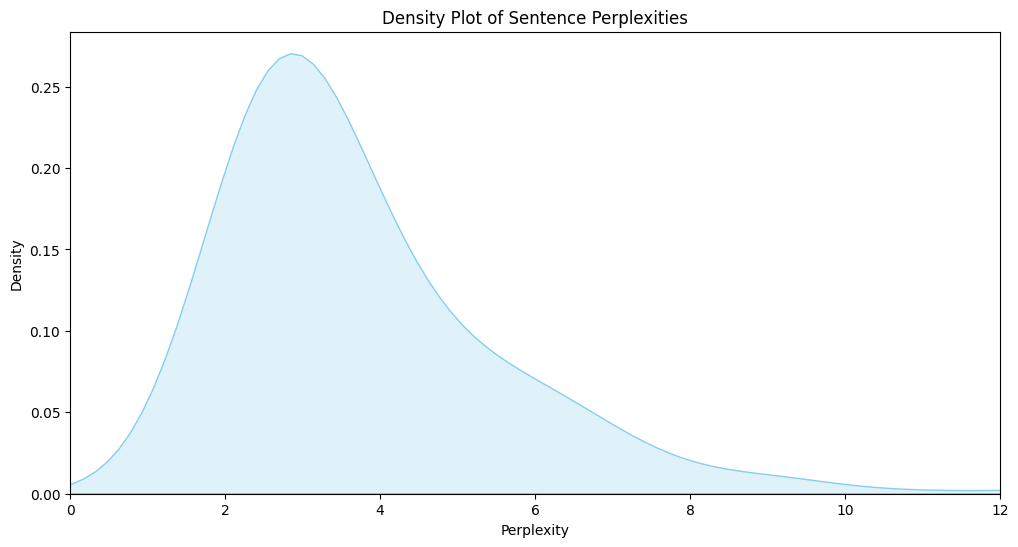

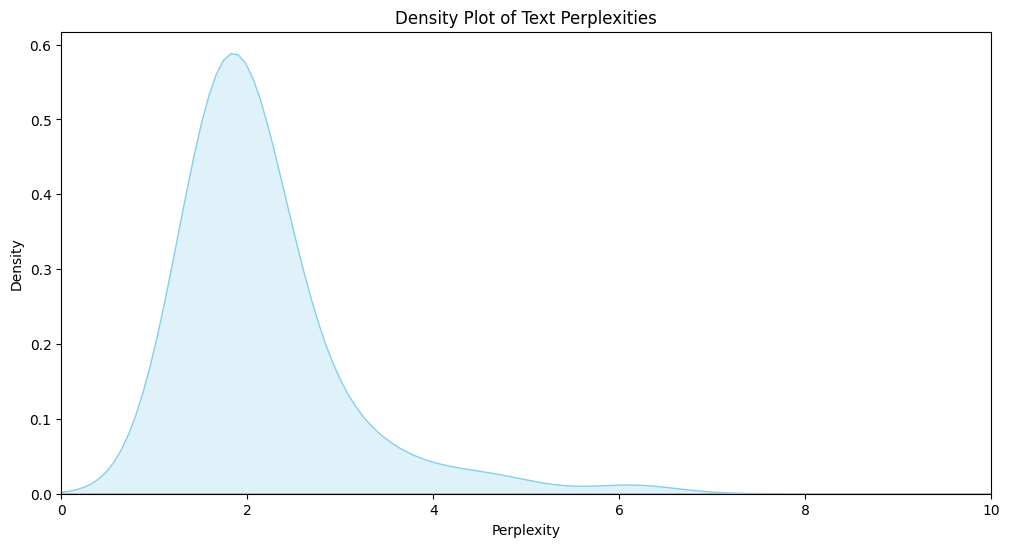

In [8]:
plot_perplexities(statistics['sentence_perplexities'],statistics['text_perplexities'])